### The German Traffic Sign Benchmark

Student Name 1: Matteo Anelli

Student Name 2: José Manuel Pérez

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [1]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


--2019-05-09 11:27:14--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.92.108.98, 34.232.40.183, 52.201.75.180, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.92.108.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14991793 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  14.30M  5.99MB/s    in 2.4s    

2019-05-09 11:27:17 (5.99 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [14991793/14991793]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [2]:
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
download = drive.CreateFile({'id': '1FP5jyKWT2gArNPKrx4YBZNG4lOTjHLHk'})
download.GetContentFile('Full.zip')
!unzip Full.zip

Archive:  Full.zip
replace FullIJCNN2013/00000.ppm? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (32, 32)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [0]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

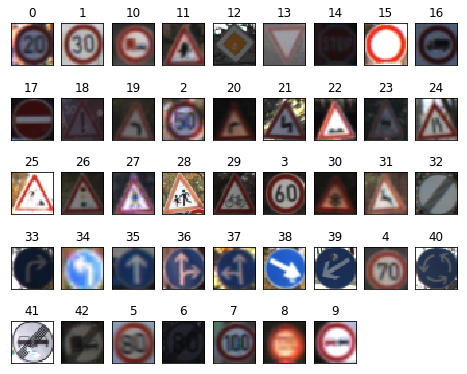

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [0]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

In [16]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

tbc=TensorBoardColab()


Wait for 8 seconds...
TensorBoard link:
http://0a5fedcf.ngrok.io


![texto alternativo](https://)*[italicized text](https://)*### Assignment 1: Multi-Layer Perceptron

---


In [41]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import optimizers

mlp = Sequential()
mlp.add(Flatten(input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3)))
mlp.add(Dense(2048, activation='relu'))
mlp.add(Dropout(rate=0.4))
mlp.add(Dense(1024, activation='relu'))
mlp.add(Dropout(rate=0.2))
mlp.add(Dense(512, activation='relu'))
mlp.add(Dropout(rate=0.15))
mlp.add(Dense(256, activation='relu'))
mlp.add(Dropout(rate=0.1))
mlp.add(Dense(128, activation='relu'))
mlp.add(Dense(num_classes))
mlp.add(Activation('softmax'))

opt = optimizers.SGD(lr=0.001, decay=1e-5, momentum=0.9, nesterov=True)
mlp.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_84 (Dense)             (None, 2048)              6293504   
_________________________________________________________________
dropout_58 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_85 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_59 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_86 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_60 (Dropout)         (None, 512)               0         
__________

In [42]:
data = mlp.fit(tr_signs, tr_labels, batch_size=32, epochs=400, verbose=2, validation_data=(va_signs, va_labels), callbacks=[TensorBoardColabCallback(tbc)])

start = time()
loss, acc = mlp.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('MLP took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Train on 600 samples, validate on 252 samples
Epoch 1/400
 - 1s - loss: 3.7850 - acc: 0.0233 - val_loss: 3.6930 - val_acc: 0.0556
Epoch 2/400
 - 0s - loss: 3.6412 - acc: 0.0650 - val_loss: 3.6112 - val_acc: 0.0556
Epoch 3/400
 - 0s - loss: 3.5222 - acc: 0.0883 - val_loss: 3.5668 - val_acc: 0.0675
Epoch 4/400
 - 0s - loss: 3.4496 - acc: 0.0950 - val_loss: 3.5467 - val_acc: 0.1032
Epoch 5/400
 - 0s - loss: 3.4335 - acc: 0.0767 - val_loss: 3.5268 - val_acc: 0.0992
Epoch 6/400
 - 0s - loss: 3.3737 - acc: 0.1233 - val_loss: 3.5017 - val_acc: 0.1429
Epoch 7/400
 - 0s - loss: 3.3297 - acc: 0.1317 - val_loss: 3.4758 - val_acc: 0.1667
Epoch 8/400
 - 0s - loss: 3.2803 - acc: 0.1600 - val_loss: 3.4536 - val_acc: 0.1706
Epoch 9/400
 - 0s - loss: 3.2486 - acc: 0.1633 - val_loss: 3.4020 - val_acc: 0.1667
Epoch 10/400
 - 0s - loss: 3.1956 - acc: 0.1933 - val_loss: 3.3612 - val_acc: 0.1706
Epoch 11/400
 - 0s - loss: 3.1643 - acc: 0.1850 - val_loss: 3.3367 - val_acc: 0.1508
Epoch 12/400
 - 0s - loss: 3